In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import ceil
from scipy.stats import kstest, f_oneway

### Directorios de csv

In [7]:
RESULTS = 'results/'
PLOTS = f'{RESULTS}plots/'
REPORTS = f'{RESULTS}reports'
BFE = f'{RESULTS}best_fitness_execution/'

### Funciones de Utilidad

In [8]:
def normality_test(sample): 
        standarized_sample = (sample - np.mean(sample)) / np.std(sample, ddof=1)
        return kstest(standarized_sample, "norm", alternative='two-sided').pvalue

def anova_test(samples):
        return f_oneway(*samples).pvalue

In [7]:
def print_hist_plots(df, plot_name, size=(20,20)):
    fig, axs = plt.subplots(ceil(len(df.columns)/2), 2, figsize=size)
    for col,ax in zip(df.columns, axs.flatten()):
        ax.hist(df[col], density=True)
        ax.set_title(col)
        xlim = ax.get_xlim()
        
        # kernel density estimate
        df[col].plot.density(color='k', alpha=0.5, ax=ax)
        
        ax.set_xlim(xlim)
        ax.legend(labels=['KDE'], frameon=False)
        ax.text(0.98, 0.9, f"p-value={normality_test(df[col]):.5f}", verticalalignment ='top', horizontalalignment ='right', transform = ax.transAxes, color ='black', fontsize = 12)
        
        ax.set_title(col, fontsize=14, pad=15)
        
    fig.savefig(f"{PLOTS}{plot_name}.png")

In [41]:
from operator import gt, lt

def get_comparable_configs_dict(p_val_df):
    return { (r,c):(p_val_df.index[r],p_val_df.columns[c]) for (r,c) in zip(*np.where(p_val_df[p_val_df < 0.05].notnull())) if r<c }

def get_differences_df(p_val_df, results_df):
    rs= {}
    idx=0
    temp_df = results_df[["best_historical_fitness", "avg_best_fitness", "std_fitness", "avg_time"]]
    for (r,c),(c1,c2) in get_comparable_configs_dict(p_val_df).items():
        resta = temp_df[temp_df.index==r].values - temp_df[temp_df.index==c].values
        reshaped = list(resta.reshape(-1))
        configs = [c1, c2]
        configs.extend(reshaped)
        rs[idx] = configs
        idx+=1
    return pd.DataFrame.from_dict(data=rs, columns=["Config1", "Config2", *temp_df.columns], orient='index')

def get_ranking(p_val_df, results_df):
    resultados_significativos = get_differences_df(p_val_df, results_df)
    gl = resultados_significativos.groupby("Config1")
    gr = resultados_significativos.groupby("Config2")
    app = lambda df, g: len(df.get_group(g)) if g in df.groups.keys() else 0

    win = lambda df, g, operator: \
        len( df.get_group(g)[ operator(df.get_group(g)["avg_best_fitness"], 0) ] ) if g in df.groups.keys() else 0
    win_left = lambda df, g: win(df, g, lt)
    win_right = lambda df, g: win(df, g, gt)

    ranking = []
    for g in set.union(set(gl.groups.keys()), set(gr.groups.keys())):
        appearances = app(gl, g) + app(gr, g)
        wins = win_left(gl, g) + win_right(gr, g)
        ranked = wins/appearances
        ranking.append([g, appearances, wins, ranked])
    ranking = pd.DataFrame(data=ranking, columns=["Config", "appearances", "wins", "ranked"])
    ranking.sort_values(by="ranked", inplace=True, ascending=False)
    return ranking


### Analisisi configuraciones Parametricas

In [9]:
parametricos = pd.read_csv(f"{BFE}best_fit_per_config_parametric.csv")
resultados = pd.read_csv(f"{RESULTS}resultados.csv")

#### Normalidad

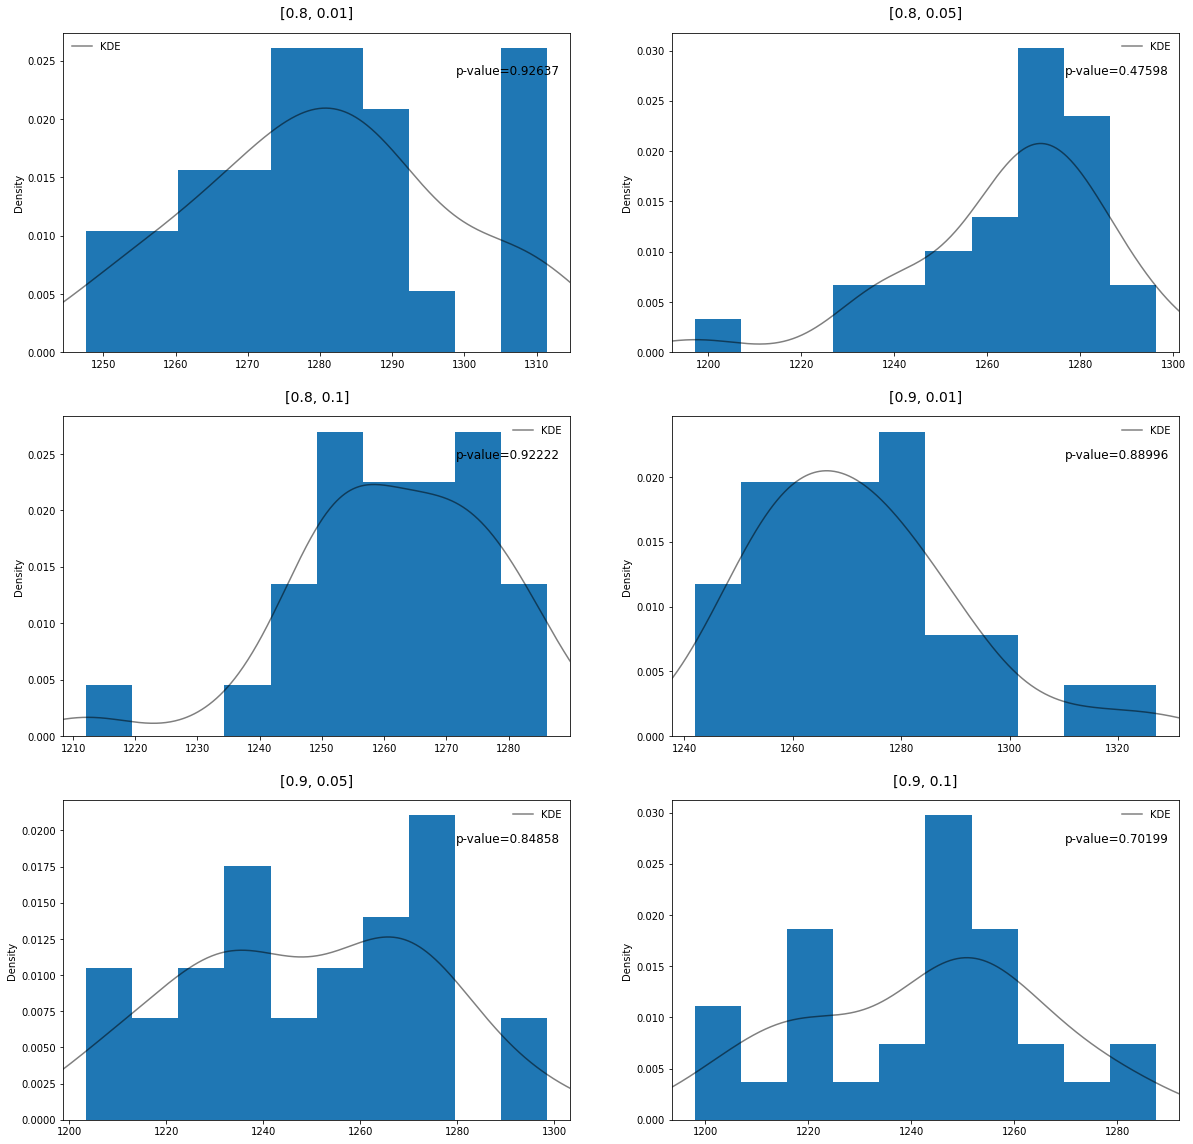

In [8]:
print_hist_plots(parametricos, "parametric")

#### ANOVA

In [9]:
f_oneway(*[parametricos[col] for col in parametricos.columns])

F_onewayResult(statistic=14.03663642461185, pvalue=1.575577368841589e-11)

The p-value turn out to be 1.5755e-11. <br>
Since the p-value is less than 0.05 hence we would reject the null hypothesis. <br>
This implies that we have sufficient proof to say that there exists a difference in the performance among four different configurations. 

#### Posthoc

##### t-Student

In [10]:
import scikit_posthocs as ph
parametricos.head()

,"[0.8, 0.01]","[0.8, 0.05]","[0.8, 0.1]","[0.9, 0.01]","[0.9, 0.05]","[0.9, 0.1]"
0,1285.671766,1296.231587,1257.136032,1282.188690,1270.801786,1247.136131
1,1277.800476,1266.708730,1277.859544,1293.368016,1203.522421,1222.599365
2,1283.520714,1282.181905,1257.915040,1267.736964,1268.195933,1278.843651
3,1268.604563,1296.280893,1212.099583,1276.484762,1238.116230,1276.717440
4,1266.432718,1197.161528,1278.339365,1276.006925,1253.702222,1248.549722


In [11]:
#convert dataframe into a single column
fitness_by_method = parametricos.melt(var_name='parameters', value_name='best_fitness')
fitness_by_method

,parameters,best_fitness
0,"[0.8, 0.01]",1285.671766
1,"[0.8, 0.01]",1277.800476
2,"[0.8, 0.01]",1283.520714
3,"[0.8, 0.01]",1268.604563
4,"[0.8, 0.01]",1266.432718
...,...,...
175,"[0.9, 0.1]",1218.881627
176,"[0.9, 0.1]",1227.741012
177,"[0.9, 0.1]",1206.390020
178,"[0.9, 0.1]",1256.998393


In [12]:
#tstudent posthoc
ttest_posthoc = ph.posthoc_ttest(fitness_by_method, val_col='best_fitness', group_col='parameters', p_adjust='holm')
ttest_posthoc

,"[0.8, 0.01]","[0.8, 0.05]","[0.8, 0.1]","[0.9, 0.01]","[0.9, 0.05]","[0.9, 0.1]"
"[0.8, 0.01]",1.000000e+00,0.018151,0.000669,0.279405,0.000009,2.566644e-08
"[0.8, 0.05]",1.815146e-02,1.000000,0.603387,0.499834,0.085718,2.846815e-03
"[0.8, 0.1]",6.690714e-04,0.603387,1.000000,0.147607,0.147607,4.044384e-03
"[0.9, 0.01]",2.794054e-01,0.499834,0.147607,1.000000,0.002484,2.060808e-05
"[0.9, 0.05]",9.193886e-06,0.085718,0.147607,0.002484,1.000000,6.033868e-01
"[0.9, 0.1]",2.566644e-08,0.002847,0.004044,0.000021,0.603387,1.000000e+00


##### Probando con Tukey

In [58]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey2_posthoc = pairwise_tukeyhsd(endog=fitness_by_method['best_fitness'], groups=fitness_by_method['parameters'], alpha=0.05)
tukey2_posthoc.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
"[0.8, 0.01]","[0.8, 0.05]",-15.9054,0.0371,-31.2401,-0.5708,True
"[0.8, 0.01]","[0.8, 0.1]",-18.8052,0.0068,-34.1399,-3.4706,True
"[0.8, 0.01]","[0.9, 0.01]",-8.6888,0.578,-24.0235,6.6458,False
"[0.8, 0.01]","[0.9, 0.05]",-31.4542,0.0,-46.7888,-16.1195,True
"[0.8, 0.01]","[0.9, 0.1]",-38.022,0.0,-53.3566,-22.6873,True
"[0.8, 0.05]","[0.8, 0.1]",-2.8998,0.9942,-18.2345,12.4348,False
"[0.8, 0.05]","[0.9, 0.01]",7.2166,0.753,-8.1181,22.5512,False
"[0.8, 0.05]","[0.9, 0.05]",-15.5488,0.0448,-30.8834,-0.2141,True
"[0.8, 0.05]","[0.9, 0.1]",-22.1166,0.0007,-37.4512,-6.7819,True
"[0.8, 0.1]","[0.9, 0.01]",10.1164,0.405,-5.2183,25.451,False


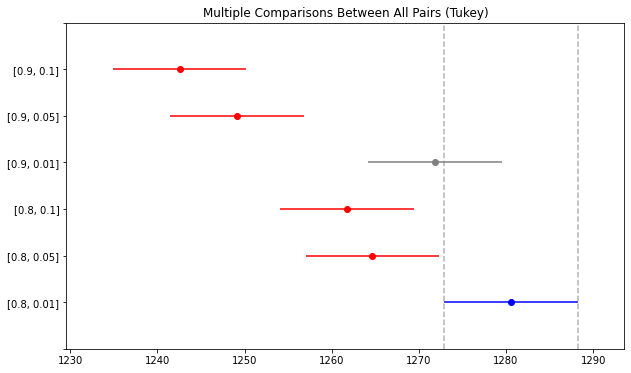

In [69]:
fig = tukey2_posthoc.plot_simultaneous(comparison_name='[0.8, 0.01]')

#### Ranking

In [44]:
get_differences_df(ttest_posthoc, resultados)

,Config1,Config2,best_historical_fitness,avg_best_fitness,std_fitness,avg_time
0,"[0.8, 0.01]","[0.8, 0.05]",19.375119,15.905402,-3.386813,-4.313221
1,"[0.8, 0.01]","[0.8, 0.1]",18.990675,18.805210,1.499448,-10.697836
2,"[0.8, 0.01]","[0.9, 0.05]",12.230020,31.454173,-7.805998,-35.498707
3,"[0.8, 0.01]","[0.9, 0.1]",14.613750,38.021956,-5.762953,-37.318566
4,"[0.8, 0.05]","[0.9, 0.1]",-4.761369,22.116554,-2.376140,-33.005345
5,"[0.8, 0.1]","[0.9, 0.1]",-4.376925,19.216745,-7.262401,-26.620731
6,"[0.9, 0.01]","[0.9, 0.05]",4.286667,22.765354,-6.392886,-1.890985
7,"[0.9, 0.01]","[0.9, 0.1]",6.670397,29.333137,-4.349841,-3.710844


In [45]:
get_ranking(ttest_posthoc, resultados)

,Config,appearances,wins,ranked
2,"[0.9, 0.05]",2,2,1.0
3,"[0.9, 0.1]",4,4,1.0
1,"[0.8, 0.1]",2,1,0.5
4,"[0.8, 0.05]",2,1,0.5
0,"[0.8, 0.01]",4,0,0.0
5,"[0.9, 0.01]",2,0,0.0


In [98]:
resultados

,CXPB,MUTPB,best_historical_fitness,avg_best_fitness,std_fitness,avg_time,p-value
0,0.8,0.01,1255.752024,1280.579688,17.192971,420.956239,0.926373
1,0.8,0.05,1236.376905,1264.674286,20.579784,425.269461,0.475978
2,0.8,0.10,1236.761349,1261.774478,15.693523,431.654075,0.922218
3,0.9,0.01,1247.808671,1271.890869,18.606082,454.563961,0.889964
4,0.9,0.05,1243.522004,1249.125515,24.998969,456.454946,0.848576
5,0.9,0.10,1241.138274,1242.557732,22.955924,458.274806,0.701994


Como puede observarse en los resultados, tanto el mejor fitness histórico como promedio es mínimo para la combinación de [0.9, 0.10]. Existe evidencia para decir que esta combinacón es mejor que las demás con un nivel de confidencia del 0.05 excepto por [0.9, 0.05]. Aún así, se decide tomar [0.9, 0.10] dado que la diferencia en tiempo no es significativa y tuvo mejores resultados en los demás atributos.

### Analisis de Configuraciones Informales

In [57]:
#tstudent posthoc en tests informales

informales = pd.read_csv(f"{BFE}best_fit_per_config_informal.csv")
best_fitness_informal = pd.read_csv(f"{RESULTS}informal.csv")

print(informales.head())
best_fitness_informal


           [2]          [3]
0  1295.056369  1332.464226
1  1314.083492  1307.888571
2  1321.953571  1319.988810
3  1280.405496  1286.903373
4  1315.279841  1268.527599


,tournament_size,best_historical_fitness,avg_best_fitness,std_fitness,avg_time,p-value
0,2,1277.845000,1287.592392,18.530151,478.450672,0.872560
1,3,1337.026012,1295.067064,21.619478,491.637074,0.986265


Revisando otros trabajos (machin) parece que en los informales no hay que hacer ningun test, se fijan el que da promedio minimo y listo

In [58]:
informales.mean()

[2]    1287.592392
[3]    1295.067064
dtype: float64

nos quedariamos con tournsize = 2

#### Normalidad

In [ ]:
#Test de normalidad
print_hist_plots(informales, "informal", size=(20,10))

De aquí resulta que no se rechaza la hipótesis de normalidad.

#### ANOVA

In [247]:
# anova test
f_oneway(*[informales[col] for col in informales.columns])

F_onewayResult(statistic=1.9984146097807995, pvalue=0.16280886774821413)

Como el p-value no es menor a 0.05 entonces no se puede rechazar la $H_{0}$ y entonces no hay evidencia estadisticamente significativa para decir que hay una diferencia entre la media de uno y otro.

#### Esto no iria

In [47]:
#add column from parametric
informales["best_config"] = parametricos["[0.9, 0.1]"]
informales

,[2],[3],best_config
0,1295.056369,1332.464226,1247.136131
1,1314.083492,1307.888571,1222.599365
2,1321.953571,1319.988810,1278.843651
3,1280.405496,1286.903373,1276.717440
4,1315.279841,1268.527599,1248.549722
5,1293.773413,1301.607123,1249.432738
6,1277.621806,1256.683413,1287.581607
7,1262.963056,1272.258710,1197.936944
8,1320.792480,1273.519583,1243.948294
9,1304.860794,1304.547143,1269.324603


In [48]:
#convert dataframe into a single column
fitness_by_method = informales.melt(var_name='parameters', value_name='best_fitness')
fitness_by_method

,parameters,best_fitness
0,[2],1295.056369
1,[2],1314.083492
2,[2],1321.953571
3,[2],1280.405496
4,[2],1315.279841
...,...,...
85,best_config,1218.881627
86,best_config,1227.741012
87,best_config,1206.390020
88,best_config,1256.998393


In [49]:
posthoc = ph.posthoc_ttest(fitness_by_method, val_col='best_fitness', group_col='parameters', p_adjust='holm')
posthoc

,[2],[3],best_config
[2],1.000000e+00,1.628089e-01,5.234705e-11
[3],1.628089e-01,1.000000e+00,4.505137e-12
best_config,5.234705e-11,4.505137e-12,1.000000e+00


De estos resultados se observa una no tan clara diferencia entre distintos parámetros para la selección por torneos. Sin embargo, la superioridad de la selección elitista es percibida como considerablemente mejor, por lo que se decide conservar este parámetro para la etapa posterior. 

### Eleccion de Mejor Configuracion

Informal -> tournament_size = 2 <br>
Formal -> [CXPB, MUTPB] = [0.9, 0.1] <br>	

### Analisis Greedy

In [52]:
greedy = pd.read_csv(f"{BFE}best_fit_per_config_greedy.csv")
greedy.head()

,local_search-fox.jpg,gaussian-fox.jpg,local_search-monalisa_sqr.jpg,gaussian-monalisa_sqr.jpg,local_search-old_man.jpeg,gaussian-old_man.jpeg
0,1151.139189,746.074643,1285.100136,579.912603,2509.528899,1922.474685
1,1179.543081,840.159904,1058.013657,515.004471,2806.315866,2066.489939
2,1066.652060,733.045988,960.882554,592.082942,2670.118541,2105.057894
3,1367.556024,731.768474,1710.703087,674.023901,2611.519501,2181.745312
4,1132.066042,737.350577,1277.790868,558.138893,2769.137322,2001.684086


In [53]:
instancia1, instancia2, instancia3 = (greedy.iloc[0:30,i*3:i*3+3] for i in range(3))

#### Anderson Darling ?

In [110]:
#do anderson darling test
from scipy.stats import anderson
for idx, instancia in enumerate([instancia1, instancia2, instancia3]):
    print(f"<---Instancia {idx}--->")
    for col in instancia.columns:
        print(col)
        print(anderson(instancia[col], dist='norm'))

<---Instancia 0--->
local_search-fox.jpg
AndersonResult(statistic=0.8746999266647748, critical_values=array([0.521, 0.593, 0.712, 0.83 , 0.988]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))
gaussian-fox.jpg
AndersonResult(statistic=0.7114886157343747, critical_values=array([0.521, 0.593, 0.712, 0.83 , 0.988]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))
EA-fox.jpg
AndersonResult(statistic=0.3889225356137693, critical_values=array([0.521, 0.593, 0.712, 0.83 , 0.988]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))
<---Instancia 1--->
local_search-monalisa_sqr.jpg
AndersonResult(statistic=1.053989893606225, critical_values=array([0.521, 0.593, 0.712, 0.83 , 0.988]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))
gaussian-monalisa_sqr.jpg
AndersonResult(statistic=0.1956408002998522, critical_values=array([0.521, 0.593, 0.712, 0.83 , 0.988]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))
EA-monalisa_sqr.jpg
AndersonResult(statis

#### Normalidad

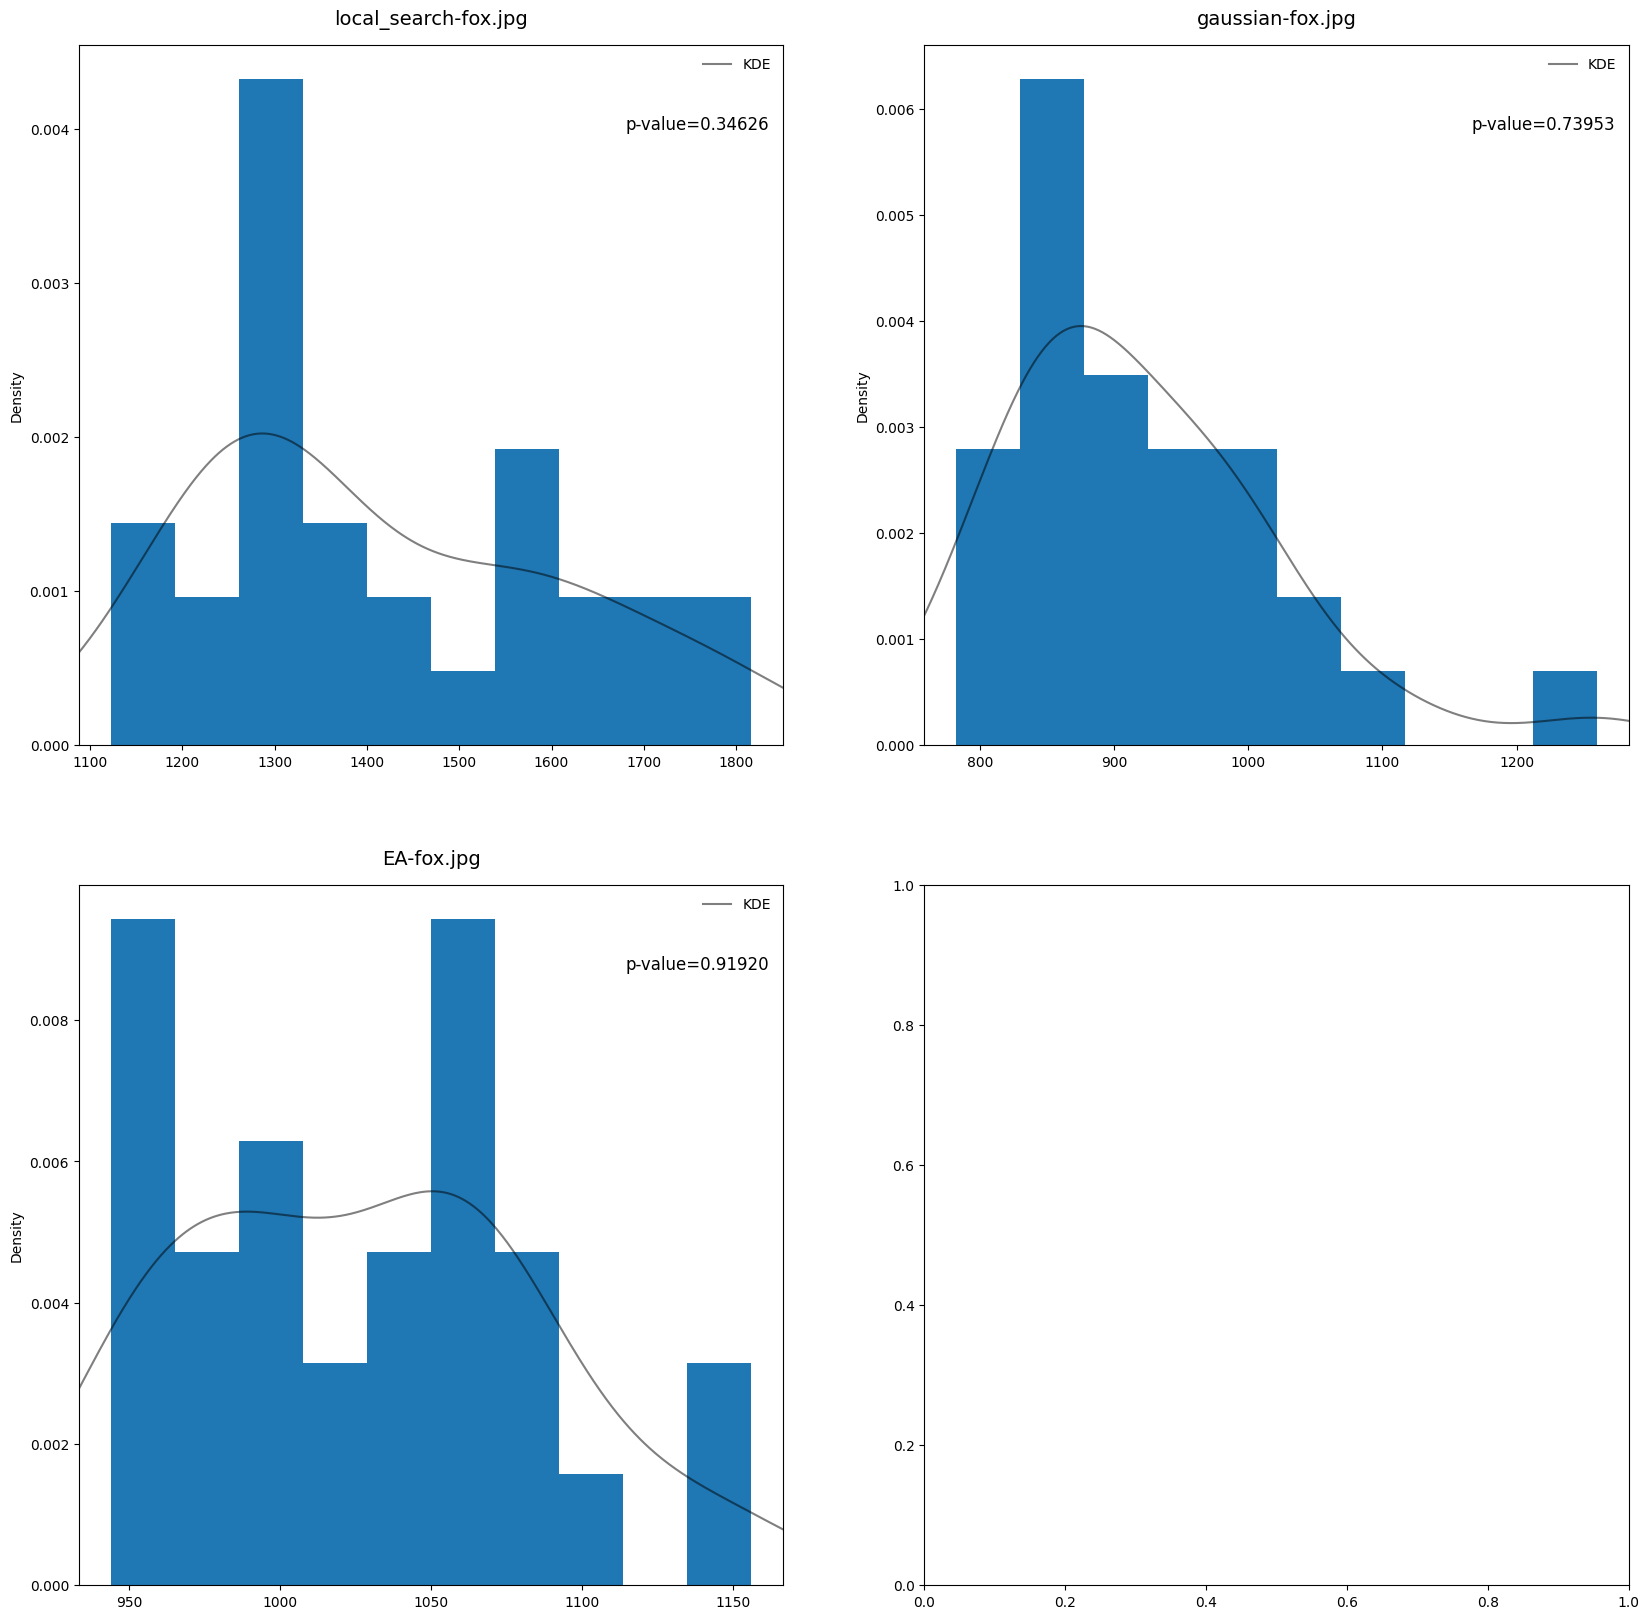

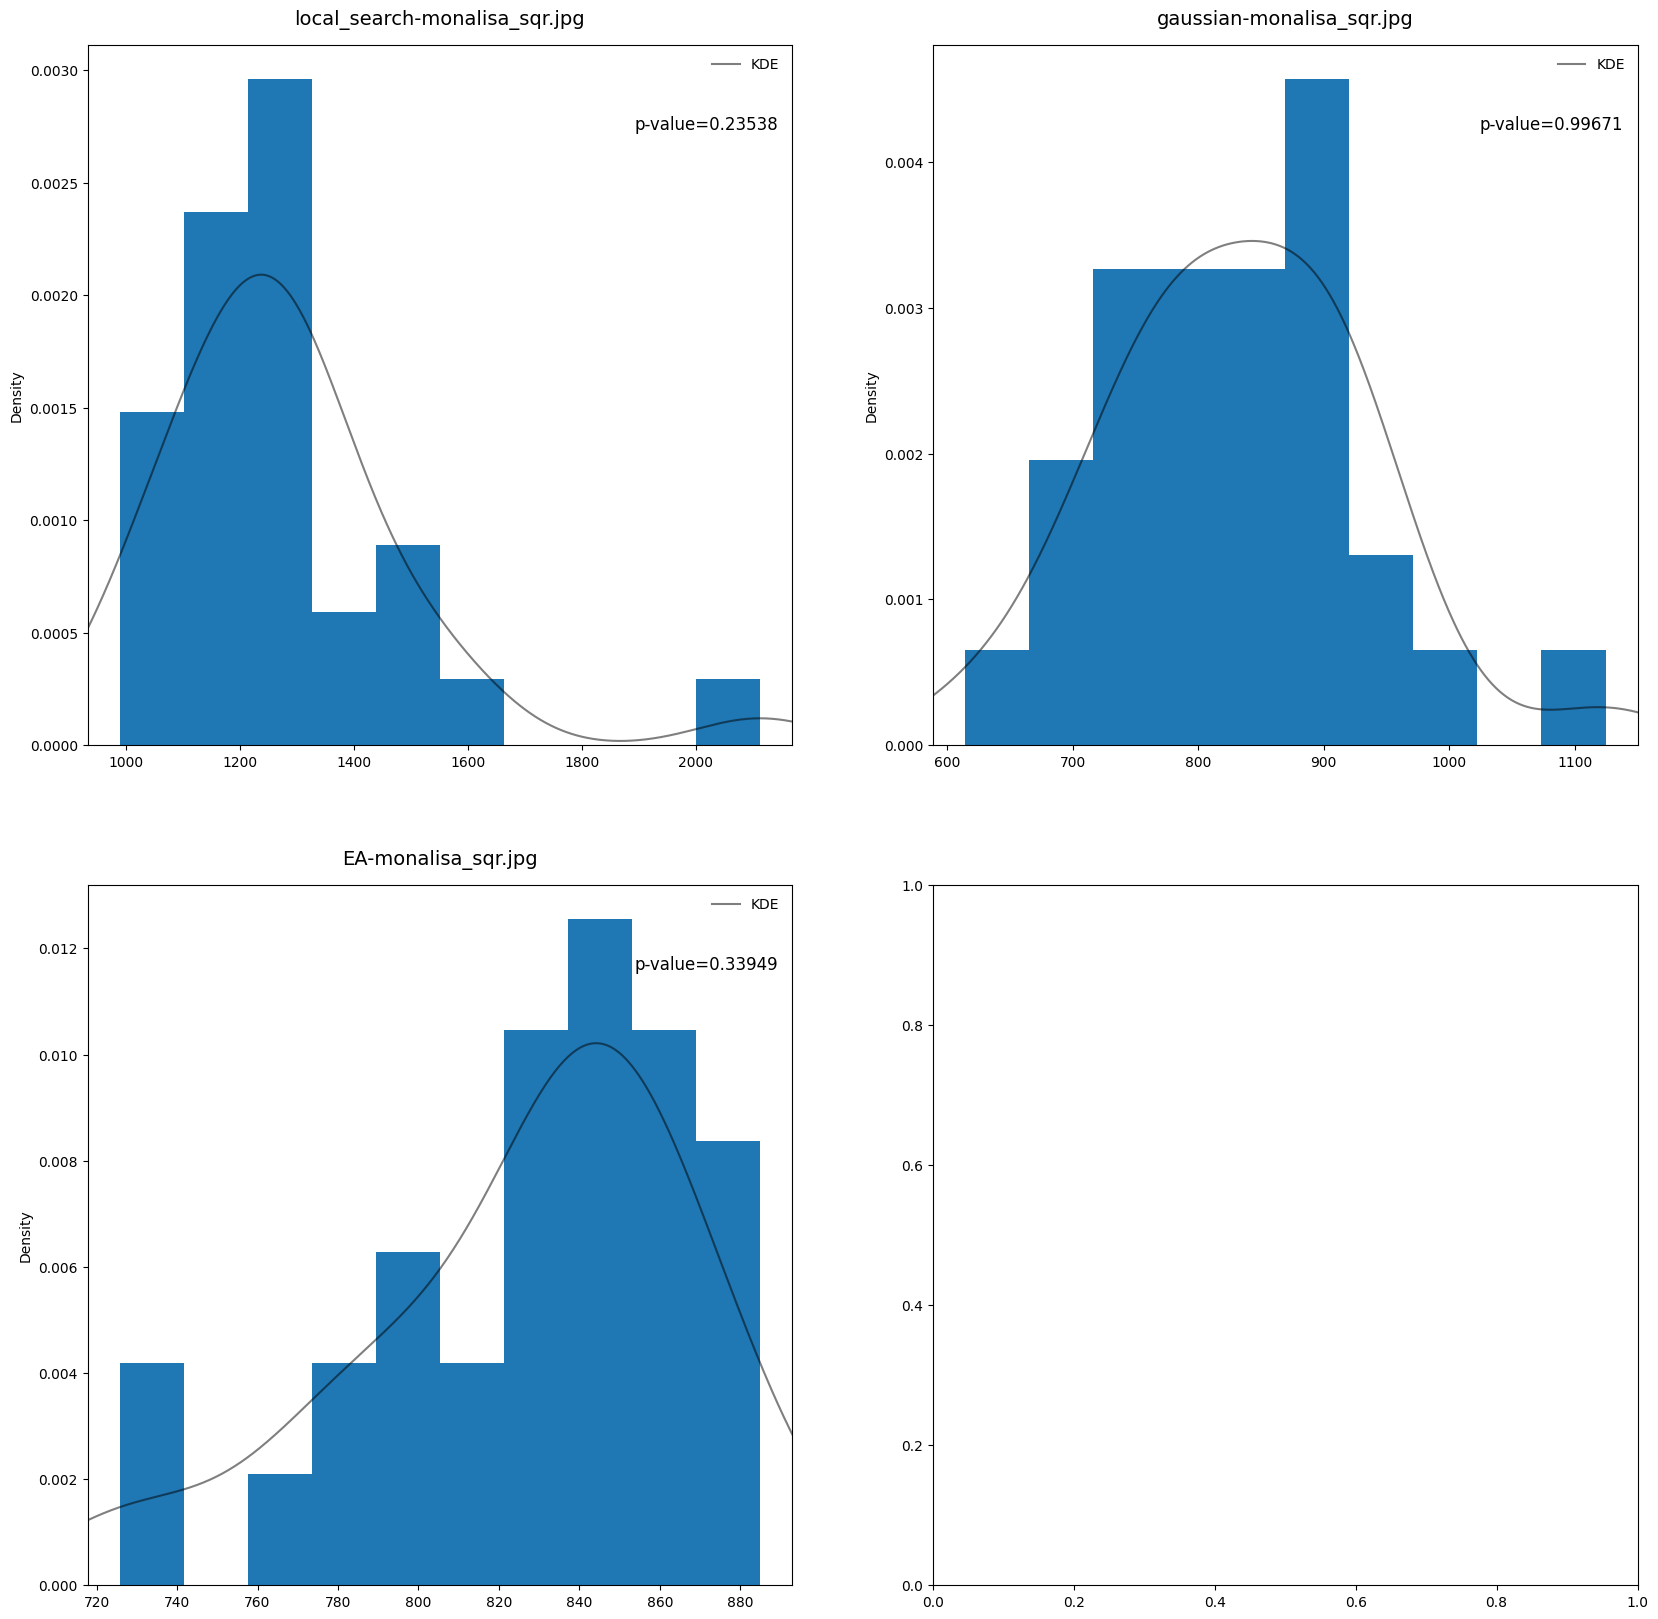

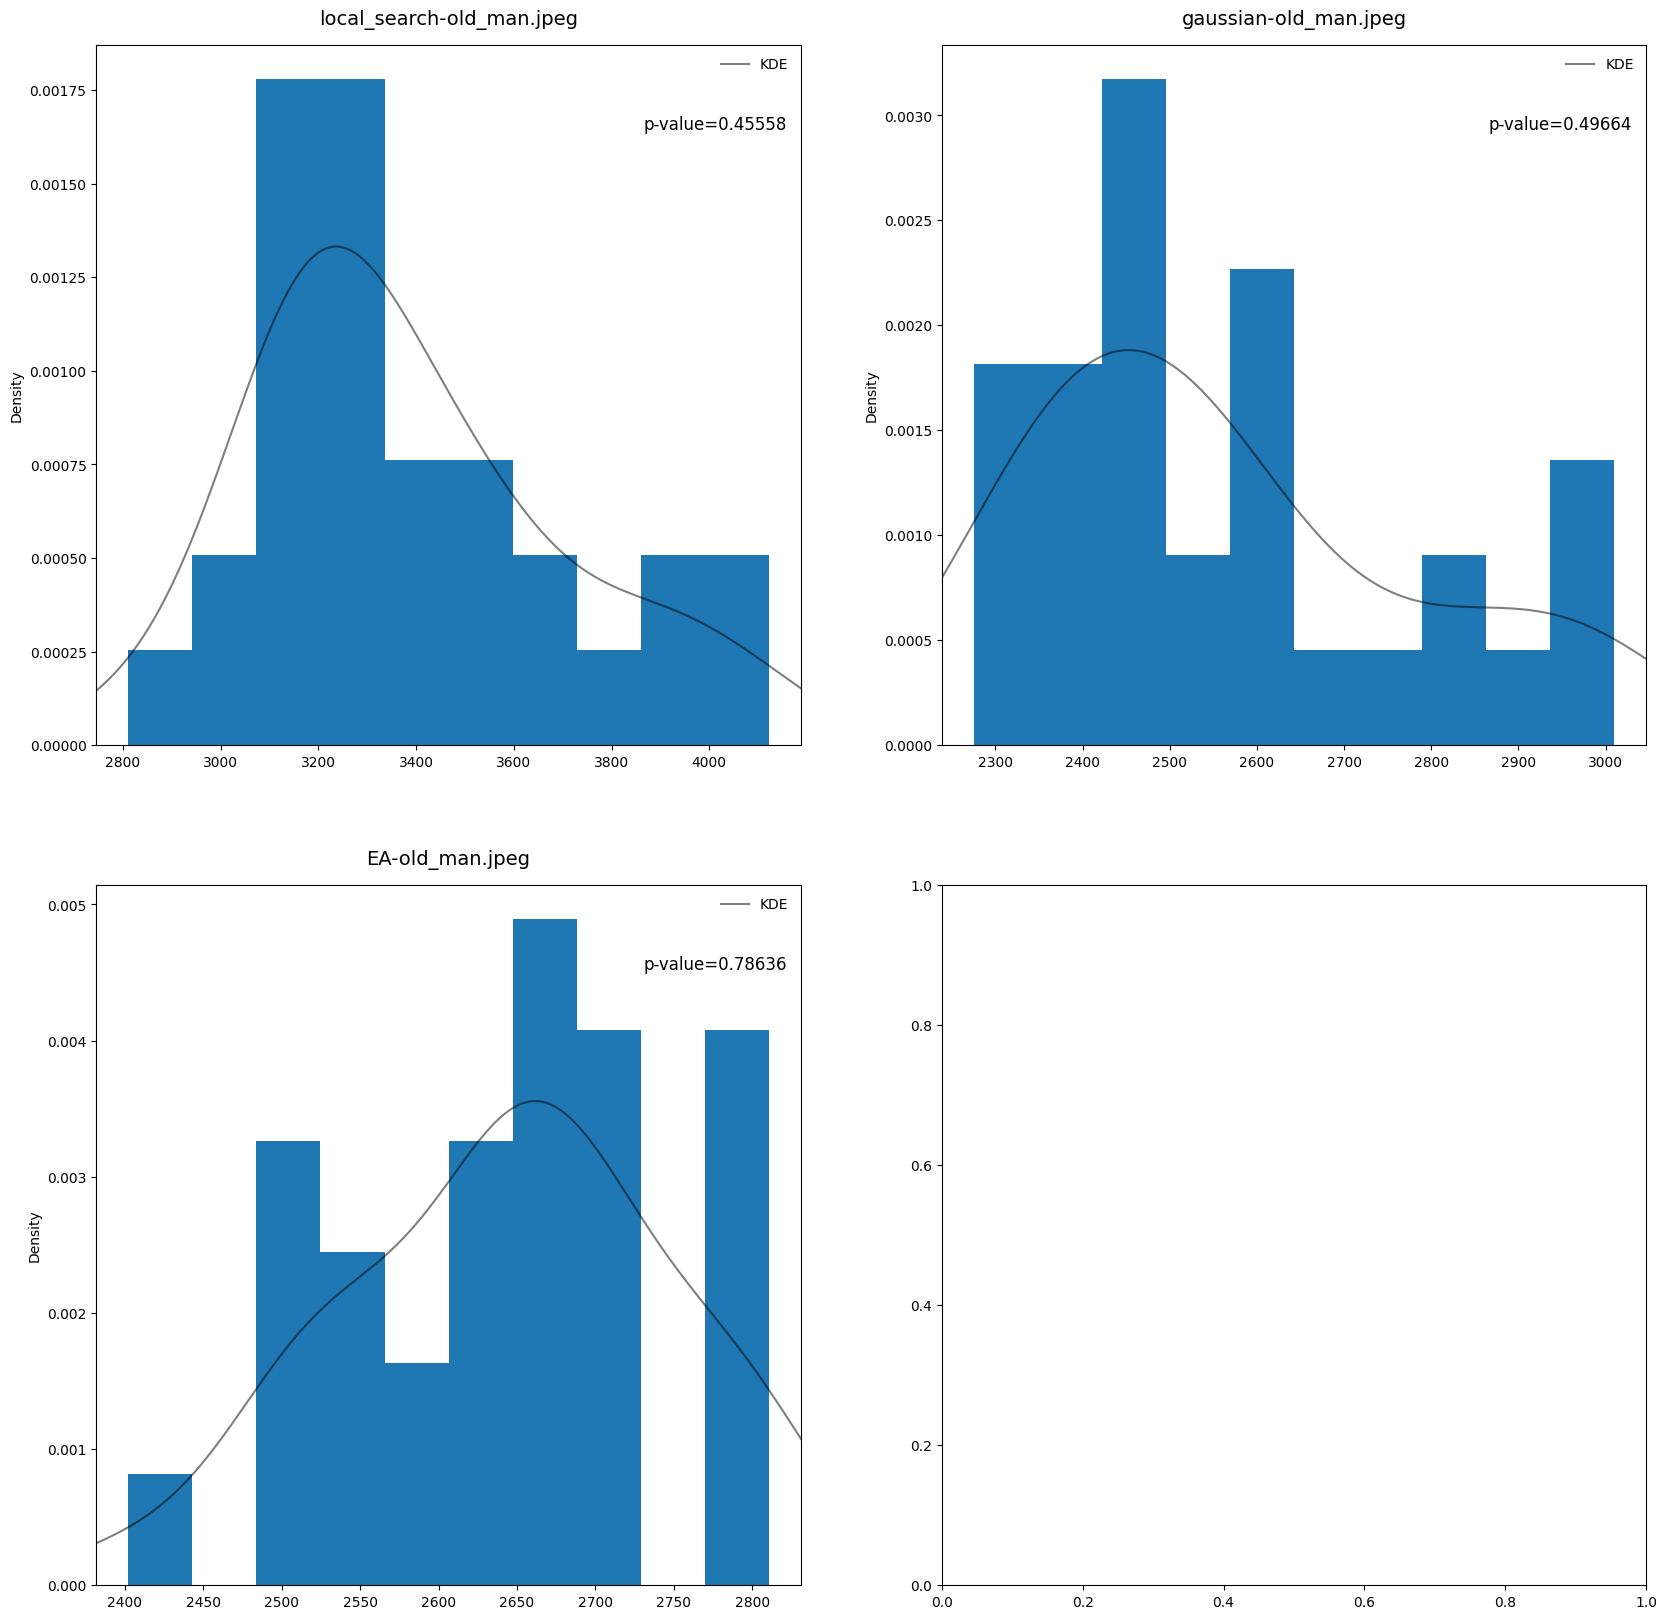

In [111]:
#Test de normalidad para cada instancia
print_hist_plots(instancia1, "greedy_instancia1")
print_hist_plots(instancia2, "greedy_instancia2")
print_hist_plots(instancia3, "greedy_instancia3")

conclusion: no se rechaza $H_{0}$ se asumen los datos como normales

### Comparacion de Algoritmos

In [112]:
#Cargar resultados de greedy
greedy_results = pd.read_csv(f"{RESULTS}greedy.csv")
greedy_results

,image,method,best_historical_fitness,avg_best_fitness,std_fitness,avg_time,p-value
0,fox.jpg,local_search,1122.658126,1414.378676,191.895384,62.053594,0.346257
1,fox.jpg,gaussian,782.300547,921.681906,101.870567,61.540513,0.739532
2,fox.jpg,EA,943.993435,1026.927912,56.754374,39.386143,0.919201
3,monalisa_sqr.jpg,local_search,987.900649,1277.371964,215.250207,76.488391,0.235379
4,monalisa_sqr.jpg,gaussian,613.993360,833.869588,102.044673,76.188068,0.996707
5,monalisa_sqr.jpg,EA,725.701769,825.780571,40.446738,51.840493,0.339486
6,old_man.jpeg,local_search,2811.260653,3379.915101,308.639692,90.820089,0.455582
7,old_man.jpeg,gaussian,2275.214010,2559.771143,215.438776,90.767007,0.496640
8,old_man.jpeg,EA,2402.107574,2643.011213,101.300553,85.284866,0.786364


#### ANOVA

In [113]:
#ANOVA
for instancia in [instancia1, instancia2, instancia3]:
    print(f_oneway(*[instancia[col] for col in instancia.columns]))

F_onewayResult(statistic=116.16243293757202, pvalue=2.722471656848322e-25)
F_onewayResult(statistic=99.51869864727527, pvalue=3.2711082814565394e-23)
F_onewayResult(statistic=116.6794422044811, pvalue=2.36530897094672e-25)


pvalues realmente bajos -> rechazar $H_{0}$, hay evidencia estadisticamente significativa para decir que hay una diferencia entre la media de almenos un par.

In [114]:
#melt
best_fitnesses_greedy = [inst.melt(var_name='method-image', value_name='best_fitness') for inst in [instancia1, instancia2, instancia3]]
best_fitnesses_greedy

[            method-image  best_fitness
 0   local_search-fox.jpg   1276.591309
 1   local_search-fox.jpg   1268.079357
 2   local_search-fox.jpg   1122.658126
 3   local_search-fox.jpg   1547.871604
 4   local_search-fox.jpg   1228.904336
 ..                   ...           ...
 85            EA-fox.jpg    993.333526
 86            EA-fox.jpg   1071.044462
 87            EA-fox.jpg   1111.733027
 88            EA-fox.jpg   1080.740739
 89            EA-fox.jpg    997.687099
 
 [90 rows x 2 columns],
                      method-image  best_fitness
 0   local_search-monalisa_sqr.jpg   1439.298955
 1   local_search-monalisa_sqr.jpg   1291.346207
 2   local_search-monalisa_sqr.jpg   1072.288847
 3   local_search-monalisa_sqr.jpg   2113.038339
 4   local_search-monalisa_sqr.jpg   1483.649388
 ..                            ...           ...
 85            EA-monalisa_sqr.jpg    861.428806
 86            EA-monalisa_sqr.jpg    881.836157
 87            EA-monalisa_sqr.jpg    858.071054
 88 

In [115]:
#student t test

for best_fitness in best_fitnesses_greedy:
    posthoc = ph.posthoc_ttest(best_fitness, val_col='best_fitness', group_col='method-image', p_adjust='holm')
    print(posthoc)


                      local_search-fox.jpg  gaussian-fox.jpg    EA-fox.jpg
local_search-fox.jpg          1.000000e+00      3.401165e-17  1.290321e-14
gaussian-fox.jpg              3.401165e-17      1.000000e+00  9.297121e-06
EA-fox.jpg                    1.290321e-14      9.297121e-06  1.000000e+00
                               local_search-monalisa_sqr.jpg  \
local_search-monalisa_sqr.jpg                   1.000000e+00   
gaussian-monalisa_sqr.jpg                       5.637891e-14   
EA-monalisa_sqr.jpg                             1.668538e-15   

                               gaussian-monalisa_sqr.jpg  EA-monalisa_sqr.jpg  
local_search-monalisa_sqr.jpg               5.637891e-14         1.668538e-15  
gaussian-monalisa_sqr.jpg                   1.000000e+00         6.929400e-01  
EA-monalisa_sqr.jpg                         6.929400e-01         1.000000e+00  
                           local_search-old_man.jpeg  gaussian-old_man.jpeg  \
local_search-old_man.jpeg               1.00

No hay evidencia significativa que demuestre que el método de mutación gaussiana es mejor que el EA excepto en la imagen fox.jpg. Además, la imagen old_man es significativa aunque no para alpha=0.05, podría considerarse también superior en ese caso para un alpha=0.10. Por otro lado, para monalisa no demuestra superioridad, y hasta el EA consigue mejor fitness promedio.


Este resultado es desalentador aunque cabe resaltar que el algoritmo evolutivo logra su objetivo en mucho menos tiempo promedio aún dada la cantidad de operaciones realizadas en un algoritmo evolutivo, donde es importante resaltar que dado el elitismo del AE el mejor fitness obtenido generalmente se lograba mucho antes del máximo de generaciones.

Es posible además que exista una configuración de los valores de mutación (Por ejemplo, de un gen o de un individuo) del algoritmo evolutivo para los cuales este tenga un comportamiento similar al algoritmo gaussiano, por lo cual se puede concluir que aunque logra superarlo probablemente exista una configuración que logre mejores resultados, dado que en escencia se está realizando la misma operación aunque sin otros operadores característicos de un AE.